## Log data munging and EDA

Just getting set up, testing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sys
sys.path.insert(0,'../')
import mysticbit
from mysticbit import munging, ml

In [4]:
df_logs = munging.load_log_data()
df_logs.head()

,PSEUDO_DEPTH,TEMP,CALI,GR,ILD,NPHI,RHOB,DT,TVD,TVDSS,...,PHIE,PHIT,SW,EF,PERFOS,RES_ID,WELL_ID,X,Y,HACKANAME
0,2074.53,87.19,10.31,55.08,3.3128,0.1678,2.3124,108.95,1588.62,1566.62,...,0.0591,0.2066,0.5863,5,0,3005,210075859,15,20.0,B03
1,2074.68,87.20,10.25,52.89,3.6592,0.1739,2.2895,110.91,1588.77,1566.77,...,0.0871,0.2222,0.5225,5,0,3005,210075859,15,20.0,B03
2,2074.83,87.20,10.20,52.54,4.1220,0.1618,2.2686,114.92,1588.92,1566.92,...,0.0730,0.2061,0.5004,5,0,3005,210075859,15,20.0,B03
3,2074.98,87.21,10.18,54.36,4.7189,0.1448,2.2533,119.66,1589.06,1567.06,...,0.0335,0.1768,0.4566,5,0,3005,210075859,15,20.0,B03
4,2075.90,87.24,9.76,48.13,13.0483,0.1085,2.0885,126.26,1589.94,1567.94,...,0.0331,0.1412,0.2211,1,1,3005,210075859,15,20.0,B03


C:\Users\Connor\AppData\Local\conda\conda\envs\mysticbit\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


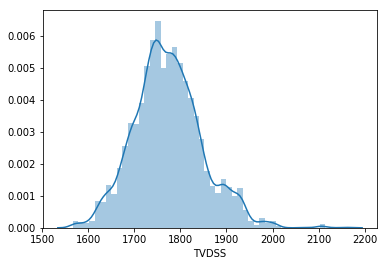

In [5]:
sns.distplot(df_logs.TVDSS)

In [6]:
df_logs.columns

Index(['PSEUDO_DEPTH', 'TEMP', 'CALI', 'GR', 'ILD', 'NPHI', 'RHOB', 'DT',
       'TVD', 'TVDSS', 'VCL', 'PHIE', 'PHIT', 'SW', 'EF', 'PERFOS', 'RES_ID',
       'WELL_ID', 'X', 'Y', 'HACKANAME'],
      dtype='object')

In [7]:
df_ml = munging.create_ml_dataframe(df_logs)
df_ml.head()

,HACKANAME,TVDSS,RES_ID,GR,GR_lag_1,GR_lag_2,GR_lag_3,GR_futr_5,GR_futr_10
0,B03,1569,3005.0,42.234286,36.278571,51.245000,53.503333,49.958333,58.120000
1,B03,1570,3005.0,34.288000,42.234286,36.278571,51.245000,58.601429,57.525000
2,B03,1571,3005.0,36.400000,34.288000,42.234286,36.278571,51.303333,47.723333
3,B03,1572,3005.0,57.498000,36.400000,34.288000,42.234286,52.490000,49.120000
4,B03,1581,3005.0,55.180000,57.498000,36.400000,34.288000,53.040000,57.418571


In [9]:
df_ml_train, df_ml_test = ml.train_test_split(df_ml)

Train well:  {'B08', 'G06', 'B13', 'G070', 'G08', 'G12', 'G16', 'G15', 'B14', 'G10', 'B0700', 'B12', 'B200', 'G17', 'G09'}
Test wells:  {'B06', 'B05', 'B03'}


In [14]:
from sklearn.model_selection import LeavePGroupsOut

# Cross validation

X_train = df_ml_train[['GR', 'GR_lag_1']]
y_train = df_ml_train['GR_futr_5']
grps_train = df_ml_train['HACKANAME']

cv = LeavePGroupsOut(2)
n_splits = cv.get_n_splits(X_train, y_train, grps_train)
n_splits

105

In [16]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

In [17]:
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)

In [18]:
df_ml_train['GR_futr_5_pred'] = y_train_pred

C:\Users\Connor\AppData\Local\conda\conda\envs\mysticbit\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [36]:
bit_depth = 1640
well_name = 'G06'
pred_row = df_ml_train[(df_ml_train.HACKANAME == well_name) &
                       (df_ml_train.TVDSS == bit_depth)]

In [39]:
pred_row

,HACKANAME,TVDSS,RES_ID,GR,GR_lag_1,GR_lag_2,GR_lag_3,GR_futr_5,GR_futr_10,GR_futr_5_pred
850,G06,1640,2900.0,77.27,74.54625,66.03,71.727143,59.4475,58.3925,70.276439


In [63]:
def get_log_predictions(df_ml, well_name, bit_depth, prediction_col_names = ['GR_futr_10', 'GR_futr_5_pred']):
    """ Get predictions indexed by depth """
    
    pred_row = df_ml_train[(df_ml_train.HACKANAME == well_name) &
                       (df_ml_train.TVDSS == bit_depth)]
    
    assert len(pred_row) == 1, 'No predictions found for that well at that depth'
    
    result = (pd.melt(pred_row,
                      id_vars=['HACKANAME', 'TVDSS'],
                      value_vars=prediction_col_names,
                      var_name='pred_col'
                      )
              .rename(columns={'TVDSS': 'TVDSS_bit_depth'})
              .assign(offset=lambda x: x['pred_col'].str.extract('(\d+)').astype('float'))
              .assign(log_name=lambda x: x['pred_col'].str.split('_').str[0])
              .assign(TVDSS=lambda x: x['TVDSS_bit_depth'] + x['offset'])
              )
    return result

get_log_predictions(df_ml_train, well_name, bit_depth)

,HACKANAME,TVDSS_bit_depth,pred_col,value,offset,log_name,TVDSS
0,G06,1640,GR_futr_10,58.392500,10.0,GR,1650.0
1,G06,1640,GR_futr_5_pred,70.276439,5.0,GR,1645.0
